# **MD SUMMARY: *trans*-AZO**

In [22]:
%%capture
%%js
/** vim: et:ts=4:sw=4:sts=4
 * @license RequireJS 2.3.6 Copyright jQuery Foundation and other contributors.
* Released under MIT license, https://github.com/requirejs/requirejs/blob/master/LICENSE
 */
//Not using strict: uneven strict support in browsers, #392, and causes
//problems with requirejs.exec()/transpiler plugins that may not be strict.
/*jslint regexp: true, nomen: true, sloppy: true */
/*global window, navigator, document, importScripts, setTimeout, opera */

var requirejs, require, define;
(function (global, setTimeout) {
    var req, s, head, baseElement, dataMain, src,
        interactiveScript, currentlyAddingScript, mainScript, subPath,
        version = '2.3.6',
        commentRegExp = /\/\*[\s\S]*?\*\/|([^:"'=]|^)\/\/.*$/mg,
        cjsRequireRegExp = /[^.]\s*require\s*\(\s*["']([^'"\s]+)["']\s*\)/g,
        jsSuffixRegExp = /\.js$/,
        currDirRegExp = /^\.\//,
        op = Object.prototype,
        ostring = op.toString,
        hasOwn = op.hasOwnProperty,
        isBrowser = !!(typeof window !== 'undefined' && typeof navigator !== 'undefined' && window.document),
        isWebWorker = !isBrowser && typeof importScripts !== 'undefined',
        //PS3 indicates loaded and complete, but need to wait for complete
        //specifically. Sequence is 'loading', 'loaded', execution,
        // then 'complete'. The UA check is unfortunate, but not sure how
        //to feature test w/o causing perf issues.
        readyRegExp = isBrowser && navigator.platform === 'PLAYSTATION 3' ?
                      /^complete$/ : /^(complete|loaded)$/,
        defContextName = '_',
        //Oh the tragedy, detecting opera. See the usage of isOpera for reason.
        isOpera = typeof opera !== 'undefined' && opera.toString() === '[object Opera]',
        contexts = {},
        cfg = {},
        globalDefQueue = [],
        useInteractive = false;

    //Could match something like ')//comment', do not lose the prefix to comment.
    function commentReplace(match, singlePrefix) {
        return singlePrefix || '';
    }

    function isFunction(it) {
        return ostring.call(it) === '[object Function]';
    }

    function isArray(it) {
        return ostring.call(it) === '[object Array]';
    }

    /**
     * Helper function for iterating over an array. If the func returns
     * a true value, it will break out of the loop.
     */
    function each(ary, func) {
        if (ary) {
            var i;
            for (i = 0; i < ary.length; i += 1) {
                if (ary[i] && func(ary[i], i, ary)) {
                    break;
                }
            }
        }
    }

    /**
     * Helper function for iterating over an array backwards. If the func
     * returns a true value, it will break out of the loop.
     */
    function eachReverse(ary, func) {
        if (ary) {
            var i;
            for (i = ary.length - 1; i > -1; i -= 1) {
                if (ary[i] && func(ary[i], i, ary)) {
                    break;
                }
            }
        }
    }

    function hasProp(obj, prop) {
        return hasOwn.call(obj, prop);
    }

    function getOwn(obj, prop) {
        return hasProp(obj, prop) && obj[prop];
    }

    /**
     * Cycles over properties in an object and calls a function for each
     * property value. If the function returns a truthy value, then the
     * iteration is stopped.
     */
    function eachProp(obj, func) {
        var prop;
        for (prop in obj) {
            if (hasProp(obj, prop)) {
                if (func(obj[prop], prop)) {
                    break;
                }
            }
        }
    }

    /**
     * Simple function to mix in properties from source into target,
     * but only if target does not already have a property of the same name.
     */
    function mixin(target, source, force, deepStringMixin) {
        if (source) {
            eachProp(source, function (value, prop) {
                if (force || !hasProp(target, prop)) {
                    if (deepStringMixin && typeof value === 'object' && value &&
                        !isArray(value) && !isFunction(value) &&
                        !(value instanceof RegExp)) {

                        if (!target[prop]) {
                            target[prop] = {};
                        }
                        mixin(target[prop], value, force, deepStringMixin);
                    } else {
                        target[prop] = value;
                    }
                }
            });
        }
        return target;
    }

    //Similar to Function.prototype.bind, but the 'this' object is specified
    //first, since it is easier to read/figure out what 'this' will be.
    function bind(obj, fn) {
        return function () {
            return fn.apply(obj, arguments);
        };
    }

    function scripts() {
        return document.getElementsByTagName('script');
    }

    function defaultOnError(err) {
        throw err;
    }

    //Allow getting a global that is expressed in
    //dot notation, like 'a.b.c'.
    function getGlobal(value) {
        if (!value) {
            return value;
        }
        var g = global;
        each(value.split('.'), function (part) {
            g = g[part];
        });
        return g;
    }

    /**
     * Constructs an error with a pointer to an URL with more information.
     * @param {String} id the error ID that maps to an ID on a web page.
     * @param {String} message human readable error.
     * @param {Error} [err] the original error, if there is one.
     *
     * @returns {Error}
     */
    function makeError(id, msg, err, requireModules) {
        var e = new Error(msg + '\nhttps://requirejs.org/docs/errors.html#' + id);
        e.requireType = id;
        e.requireModules = requireModules;
        if (err) {
            e.originalError = err;
        }
        return e;
    }

    if (typeof define !== 'undefined') {
        //If a define is already in play via another AMD loader,
        //do not overwrite.
        return;
    }

    if (typeof requirejs !== 'undefined') {
        if (isFunction(requirejs)) {
            //Do not overwrite an existing requirejs instance.
            return;
        }
        cfg = requirejs;
        requirejs = undefined;
    }

    //Allow for a require config object
    if (typeof require !== 'undefined' && !isFunction(require)) {
        //assume it is a config object.
        cfg = require;
        require = undefined;
    }

    function newContext(contextName) {
        var inCheckLoaded, Module, context, handlers,
            checkLoadedTimeoutId,
            config = {
                //Defaults. Do not set a default for map
                //config to speed up normalize(), which
                //will run faster if there is no default.
                waitSeconds: 7,
                baseUrl: './',
                paths: {},
                bundles: {},
                pkgs: {},
                shim: {},
                config: {}
            },
            registry = {},
            //registry of just enabled modules, to speed
            //cycle breaking code when lots of modules
            //are registered, but not activated.
            enabledRegistry = {},
            undefEvents = {},
            defQueue = [],
            defined = {},
            urlFetched = {},
            bundlesMap = {},
            requireCounter = 1,
            unnormalizedCounter = 1;

        /**
         * Trims the . and .. from an array of path segments.
         * It will keep a leading path segment if a .. will become
         * the first path segment, to help with module name lookups,
         * which act like paths, but can be remapped. But the end result,
         * all paths that use this function should look normalized.
         * NOTE: this method MODIFIES the input array.
         * @param {Array} ary the array of path segments.
         */
        function trimDots(ary) {
            var i, part;
            for (i = 0; i < ary.length; i++) {
                part = ary[i];
                if (part === '.') {
                    ary.splice(i, 1);
                    i -= 1;
                } else if (part === '..') {
                    // If at the start, or previous value is still ..,
                    // keep them so that when converted to a path it may
                    // still work when converted to a path, even though
                    // as an ID it is less than ideal. In larger point
                    // releases, may be better to just kick out an error.
                    if (i === 0 || (i === 1 && ary[2] === '..') || ary[i - 1] === '..') {
                        continue;
                    } else if (i > 0) {
                        ary.splice(i - 1, 2);
                        i -= 2;
                    }
                }
            }
        }

        /**
         * Given a relative module name, like ./something, normalize it to
         * a real name that can be mapped to a path.
         * @param {String} name the relative name
         * @param {String} baseName a real name that the name arg is relative
         * to.
         * @param {Boolean} applyMap apply the map config to the value. Should
         * only be done if this normalization is for a dependency ID.
         * @returns {String} normalized name
         */
        function normalize(name, baseName, applyMap) {
            var pkgMain, mapValue, nameParts, i, j, nameSegment, lastIndex,
                foundMap, foundI, foundStarMap, starI, normalizedBaseParts,
                baseParts = (baseName && baseName.split('/')),
                map = config.map,
                starMap = map && map['*'];

            //Adjust any relative paths.
            if (name) {
                name = name.split('/');
                lastIndex = name.length - 1;

                // If wanting node ID compatibility, strip .js from end
                // of IDs. Have to do this here, and not in nameToUrl
                // because node allows either .js or non .js to map
                // to same file.
                if (config.nodeIdCompat && jsSuffixRegExp.test(name[lastIndex])) {
                    name[lastIndex] = name[lastIndex].replace(jsSuffixRegExp, '');
                }

                // Starts with a '.' so need the baseName
                if (name[0].charAt(0) === '.' && baseParts) {
                    //Convert baseName to array, and lop off the last part,
                    //so that . matches that 'directory' and not name of the baseName's
                    //module. For instance, baseName of 'one/two/three', maps to
                    //'one/two/three.js', but we want the directory, 'one/two' for
                    //this normalization.
                    normalizedBaseParts = baseParts.slice(0, baseParts.length - 1);
                    name = normalizedBaseParts.concat(name);
                }

                trimDots(name);
                name = name.join('/');
            }

            //Apply map config if available.
            if (applyMap && map && (baseParts || starMap)) {
                nameParts = name.split('/');

                outerLoop: for (i = nameParts.length; i > 0; i -= 1) {
                    nameSegment = nameParts.slice(0, i).join('/');

                    if (baseParts) {
                        //Find the longest baseName segment match in the config.
                        //So, do joins on the biggest to smallest lengths of baseParts.
                        for (j = baseParts.length; j > 0; j -= 1) {
                            mapValue = getOwn(map, baseParts.slice(0, j).join('/'));

                            //baseName segment has config, find if it has one for
                            //this name.
                            if (mapValue) {
                                mapValue = getOwn(mapValue, nameSegment);
                                if (mapValue) {
                                    //Match, update name to the new value.
                                    foundMap = mapValue;
                                    foundI = i;
                                    break outerLoop;
                                }
                            }
                        }
                    }

                    //Check for a star map match, but just hold on to it,
                    //if there is a shorter segment match later in a matching
                    //config, then favor over this star map.
                    if (!foundStarMap && starMap && getOwn(starMap, nameSegment)) {
                        foundStarMap = getOwn(starMap, nameSegment);
                        starI = i;
                    }
                }

                if (!foundMap && foundStarMap) {
                    foundMap = foundStarMap;
                    foundI = starI;
                }

                if (foundMap) {
                    nameParts.splice(0, foundI, foundMap);
                    name = nameParts.join('/');
                }
            }

            // If the name points to a package's name, use
            // the package main instead.
            pkgMain = getOwn(config.pkgs, name);

            return pkgMain ? pkgMain : name;
        }

        function removeScript(name) {
            if (isBrowser) {
                each(scripts(), function (scriptNode) {
                    if (scriptNode.getAttribute('data-requiremodule') === name &&
                            scriptNode.getAttribute('data-requirecontext') === context.contextName) {
                        scriptNode.parentNode.removeChild(scriptNode);
                        return true;
                    }
                });
            }
        }

        function hasPathFallback(id) {
            var pathConfig = getOwn(config.paths, id);
            if (pathConfig && isArray(pathConfig) && pathConfig.length > 1) {
                //Pop off the first array value, since it failed, and
                //retry
                pathConfig.shift();
                context.require.undef(id);

                //Custom require that does not do map translation, since
                //ID is "absolute", already mapped/resolved.
                context.makeRequire(null, {
                    skipMap: true
                })([id]);

                return true;
            }
        }

        //Turns a plugin!resource to [plugin, resource]
        //with the plugin being undefined if the name
        //did not have a plugin prefix.
        function splitPrefix(name) {
            var prefix,
                index = name ? name.indexOf('!') : -1;
            if (index > -1) {
                prefix = name.substring(0, index);
                name = name.substring(index + 1, name.length);
            }
            return [prefix, name];
        }

        /**
         * Creates a module mapping that includes plugin prefix, module
         * name, and path. If parentModuleMap is provided it will
         * also normalize the name via require.normalize()
         *
         * @param {String} name the module name
         * @param {String} [parentModuleMap] parent module map
         * for the module name, used to resolve relative names.
         * @param {Boolean} isNormalized: is the ID already normalized.
         * This is true if this call is done for a define() module ID.
         * @param {Boolean} applyMap: apply the map config to the ID.
         * Should only be true if this map is for a dependency.
         *
         * @returns {Object}
         */
        function makeModuleMap(name, parentModuleMap, isNormalized, applyMap) {
            var url, pluginModule, suffix, nameParts,
                prefix = null,
                parentName = parentModuleMap ? parentModuleMap.name : null,
                originalName = name,
                isDefine = true,
                normalizedName = '';

            //If no name, then it means it is a require call, generate an
            //internal name.
            if (!name) {
                isDefine = false;
                name = '_@r' + (requireCounter += 1);
            }

            nameParts = splitPrefix(name);
            prefix = nameParts[0];
            name = nameParts[1];

            if (prefix) {
                prefix = normalize(prefix, parentName, applyMap);
                pluginModule = getOwn(defined, prefix);
            }

            //Account for relative paths if there is a base name.
            if (name) {
                if (prefix) {
                    if (isNormalized) {
                        normalizedName = name;
                    } else if (pluginModule && pluginModule.normalize) {
                        //Plugin is loaded, use its normalize method.
                        normalizedName = pluginModule.normalize(name, function (name) {
                            return normalize(name, parentName, applyMap);
                        });
                    } else {
                        // If nested plugin references, then do not try to
                        // normalize, as it will not normalize correctly. This
                        // places a restriction on resourceIds, and the longer
                        // term solution is not to normalize until plugins are
                        // loaded and all normalizations to allow for async
                        // loading of a loader plugin. But for now, fixes the
                        // common uses. Details in #1131
                        normalizedName = name.indexOf('!') === -1 ?
                                         normalize(name, parentName, applyMap) :
                                         name;
                    }
                } else {
                    //A regular module.
                    normalizedName = normalize(name, parentName, applyMap);

                    //Normalized name may be a plugin ID due to map config
                    //application in normalize. The map config values must
                    //already be normalized, so do not need to redo that part.
                    nameParts = splitPrefix(normalizedName);
                    prefix = nameParts[0];
                    normalizedName = nameParts[1];
                    isNormalized = true;

                    url = context.nameToUrl(normalizedName);
                }
            }

            //If the id is a plugin id that cannot be determined if it needs
            //normalization, stamp it with a unique ID so two matching relative
            //ids that may conflict can be separate.
            suffix = prefix && !pluginModule && !isNormalized ?
                     '_unnormalized' + (unnormalizedCounter += 1) :
                     '';

            return {
                prefix: prefix,
                name: normalizedName,
                parentMap: parentModuleMap,
                unnormalized: !!suffix,
                url: url,
                originalName: originalName,
                isDefine: isDefine,
                id: (prefix ?
                        prefix + '!' + normalizedName :
                        normalizedName) + suffix
            };
        }

        function getModule(depMap) {
            var id = depMap.id,
                mod = getOwn(registry, id);

            if (!mod) {
                mod = registry[id] = new context.Module(depMap);
            }

            return mod;
        }

        function on(depMap, name, fn) {
            var id = depMap.id,
                mod = getOwn(registry, id);

            if (hasProp(defined, id) &&
                    (!mod || mod.defineEmitComplete)) {
                if (name === 'defined') {
                    fn(defined[id]);
                }
            } else {
                mod = getModule(depMap);
                if (mod.error && name === 'error') {
                    fn(mod.error);
                } else {
                    mod.on(name, fn);
                }
            }
        }

        function onError(err, errback) {
            var ids = err.requireModules,
                notified = false;

            if (errback) {
                errback(err);
            } else {
                each(ids, function (id) {
                    var mod = getOwn(registry, id);
                    if (mod) {
                        //Set error on module, so it skips timeout checks.
                        mod.error = err;
                        if (mod.events.error) {
                            notified = true;
                            mod.emit('error', err);
                        }
                    }
                });

                if (!notified) {
                    req.onError(err);
                }
            }
        }

        /**
         * Internal method to transfer globalQueue items to this context's
         * defQueue.
         */
        function takeGlobalQueue() {
            //Push all the globalDefQueue items into the context's defQueue
            if (globalDefQueue.length) {
                each(globalDefQueue, function(queueItem) {
                    var id = queueItem[0];
                    if (typeof id === 'string') {
                        context.defQueueMap[id] = true;
                    }
                    defQueue.push(queueItem);
                });
                globalDefQueue = [];
            }
        }

        handlers = {
            'require': function (mod) {
                if (mod.require) {
                    return mod.require;
                } else {
                    return (mod.require = context.makeRequire(mod.map));
                }
            },
            'exports': function (mod) {
                mod.usingExports = true;
                if (mod.map.isDefine) {
                    if (mod.exports) {
                        return (defined[mod.map.id] = mod.exports);
                    } else {
                        return (mod.exports = defined[mod.map.id] = {});
                    }
                }
            },
            'module': function (mod) {
                if (mod.module) {
                    return mod.module;
                } else {
                    return (mod.module = {
                        id: mod.map.id,
                        uri: mod.map.url,
                        config: function () {
                            return getOwn(config.config, mod.map.id) || {};
                        },
                        exports: mod.exports || (mod.exports = {})
                    });
                }
            }
        };

        function cleanRegistry(id) {
            //Clean up machinery used for waiting modules.
            delete registry[id];
            delete enabledRegistry[id];
        }

        function breakCycle(mod, traced, processed) {
            var id = mod.map.id;

            if (mod.error) {
                mod.emit('error', mod.error);
            } else {
                traced[id] = true;
                each(mod.depMaps, function (depMap, i) {
                    var depId = depMap.id,
                        dep = getOwn(registry, depId);

                    //Only force things that have not completed
                    //being defined, so still in the registry,
                    //and only if it has not been matched up
                    //in the module already.
                    if (dep && !mod.depMatched[i] && !processed[depId]) {
                        if (getOwn(traced, depId)) {
                            mod.defineDep(i, defined[depId]);
                            mod.check(); //pass false?
                        } else {
                            breakCycle(dep, traced, processed);
                        }
                    }
                });
                processed[id] = true;
            }
        }

        function checkLoaded() {
            var err, usingPathFallback,
                waitInterval = config.waitSeconds * 1000,
                //It is possible to disable the wait interval by using waitSeconds of 0.
                expired = waitInterval && (context.startTime + waitInterval) < new Date().getTime(),
                noLoads = [],
                reqCalls = [],
                stillLoading = false,
                needCycleCheck = true;

            //Do not bother if this call was a result of a cycle break.
            if (inCheckLoaded) {
                return;
            }

            inCheckLoaded = true;

            //Figure out the state of all the modules.
            eachProp(enabledRegistry, function (mod) {
                var map = mod.map,
                    modId = map.id;

                //Skip things that are not enabled or in error state.
                if (!mod.enabled) {
                    return;
                }

                if (!map.isDefine) {
                    reqCalls.push(mod);
                }

                if (!mod.error) {
                    //If the module should be executed, and it has not
                    //been inited and time is up, remember it.
                    if (!mod.inited && expired) {
                        if (hasPathFallback(modId)) {
                            usingPathFallback = true;
                            stillLoading = true;
                        } else {
                            noLoads.push(modId);
                            removeScript(modId);
                        }
                    } else if (!mod.inited && mod.fetched && map.isDefine) {
                        stillLoading = true;
                        if (!map.prefix) {
                            //No reason to keep looking for unfinished
                            //loading. If the only stillLoading is a
                            //plugin resource though, keep going,
                            //because it may be that a plugin resource
                            //is waiting on a non-plugin cycle.
                            return (needCycleCheck = false);
                        }
                    }
                }
            });

            if (expired && noLoads.length) {
                //If wait time expired, throw error of unloaded modules.
                err = makeError('timeout', 'Load timeout for modules: ' + noLoads, null, noLoads);
                err.contextName = context.contextName;
                return onError(err);
            }

            //Not expired, check for a cycle.
            if (needCycleCheck) {
                each(reqCalls, function (mod) {
                    breakCycle(mod, {}, {});
                });
            }

            //If still waiting on loads, and the waiting load is something
            //other than a plugin resource, or there are still outstanding
            //scripts, then just try back later.
            if ((!expired || usingPathFallback) && stillLoading) {
                //Something is still waiting to load. Wait for it, but only
                //if a timeout is not already in effect.
                if ((isBrowser || isWebWorker) && !checkLoadedTimeoutId) {
                    checkLoadedTimeoutId = setTimeout(function () {
                        checkLoadedTimeoutId = 0;
                        checkLoaded();
                    }, 50);
                }
            }

            inCheckLoaded = false;
        }

        Module = function (map) {
            this.events = getOwn(undefEvents, map.id) || {};
            this.map = map;
            this.shim = getOwn(config.shim, map.id);
            this.depExports = [];
            this.depMaps = [];
            this.depMatched = [];
            this.pluginMaps = {};
            this.depCount = 0;

            /* this.exports this.factory
               this.depMaps = [],
               this.enabled, this.fetched
            */
        };

        Module.prototype = {
            init: function (depMaps, factory, errback, options) {
                options = options || {};

                //Do not do more inits if already done. Can happen if there
                //are multiple define calls for the same module. That is not
                //a normal, common case, but it is also not unexpected.
                if (this.inited) {
                    return;
                }

                this.factory = factory;

                if (errback) {
                    //Register for errors on this module.
                    this.on('error', errback);
                } else if (this.events.error) {
                    //If no errback already, but there are error listeners
                    //on this module, set up an errback to pass to the deps.
                    errback = bind(this, function (err) {
                        this.emit('error', err);
                    });
                }

                //Do a copy of the dependency array, so that
                //source inputs are not modified. For example
                //"shim" deps are passed in here directly, and
                //doing a direct modification of the depMaps array
                //would affect that config.
                this.depMaps = depMaps && depMaps.slice(0);

                this.errback = errback;

                //Indicate this module has be initialized
                this.inited = true;

                this.ignore = options.ignore;

                //Could have option to init this module in enabled mode,
                //or could have been previously marked as enabled. However,
                //the dependencies are not known until init is called. So
                //if enabled previously, now trigger dependencies as enabled.
                if (options.enabled || this.enabled) {
                    //Enable this module and dependencies.
                    //Will call this.check()
                    this.enable();
                } else {
                    this.check();
                }
            },

            defineDep: function (i, depExports) {
                //Because of cycles, defined callback for a given
                //export can be called more than once.
                if (!this.depMatched[i]) {
                    this.depMatched[i] = true;
                    this.depCount -= 1;
                    this.depExports[i] = depExports;
                }
            },

            fetch: function () {
                if (this.fetched) {
                    return;
                }
                this.fetched = true;

                context.startTime = (new Date()).getTime();

                var map = this.map;

                //If the manager is for a plugin managed resource,
                //ask the plugin to load it now.
                if (this.shim) {
                    context.makeRequire(this.map, {
                        enableBuildCallback: true
                    })(this.shim.deps || [], bind(this, function () {
                        return map.prefix ? this.callPlugin() : this.load();
                    }));
                } else {
                    //Regular dependency.
                    return map.prefix ? this.callPlugin() : this.load();
                }
            },

            load: function () {
                var url = this.map.url;

                //Regular dependency.
                if (!urlFetched[url]) {
                    urlFetched[url] = true;
                    context.load(this.map.id, url);
                }
            },

            /**
             * Checks if the module is ready to define itself, and if so,
             * define it.
             */
            check: function () {
                if (!this.enabled || this.enabling) {
                    return;
                }

                var err, cjsModule,
                    id = this.map.id,
                    depExports = this.depExports,
                    exports = this.exports,
                    factory = this.factory;

                if (!this.inited) {
                    // Only fetch if not already in the defQueue.
                    if (!hasProp(context.defQueueMap, id)) {
                        this.fetch();
                    }
                } else if (this.error) {
                    this.emit('error', this.error);
                } else if (!this.defining) {
                    //The factory could trigger another require call
                    //that would result in checking this module to
                    //define itself again. If already in the process
                    //of doing that, skip this work.
                    this.defining = true;

                    if (this.depCount < 1 && !this.defined) {
                        if (isFunction(factory)) {
                            //If there is an error listener, favor passing
                            //to that instead of throwing an error. However,
                            //only do it for define()'d  modules. require
                            //errbacks should not be called for failures in
                            //their callbacks (#699). However if a global
                            //onError is set, use that.
                            if ((this.events.error && this.map.isDefine) ||
                                req.onError !== defaultOnError) {
                                try {
                                    exports = context.execCb(id, factory, depExports, exports);
                                } catch (e) {
                                    err = e;
                                }
                            } else {
                                exports = context.execCb(id, factory, depExports, exports);
                            }

                            // Favor return value over exports. If node/cjs in play,
                            // then will not have a return value anyway. Favor
                            // module.exports assignment over exports object.
                            if (this.map.isDefine && exports === undefined) {
                                cjsModule = this.module;
                                if (cjsModule) {
                                    exports = cjsModule.exports;
                                } else if (this.usingExports) {
                                    //exports already set the defined value.
                                    exports = this.exports;
                                }
                            }

                            if (err) {
                                err.requireMap = this.map;
                                err.requireModules = this.map.isDefine ? [this.map.id] : null;
                                err.requireType = this.map.isDefine ? 'define' : 'require';
                                return onError((this.error = err));
                            }

                        } else {
                            //Just a literal value
                            exports = factory;
                        }

                        this.exports = exports;

                        if (this.map.isDefine && !this.ignore) {
                            defined[id] = exports;

                            if (req.onResourceLoad) {
                                var resLoadMaps = [];
                                each(this.depMaps, function (depMap) {
                                    resLoadMaps.push(depMap.normalizedMap || depMap);
                                });
                                req.onResourceLoad(context, this.map, resLoadMaps);
                            }
                        }

                        //Clean up
                        cleanRegistry(id);

                        this.defined = true;
                    }

                    //Finished the define stage. Allow calling check again
                    //to allow define notifications below in the case of a
                    //cycle.
                    this.defining = false;

                    if (this.defined && !this.defineEmitted) {
                        this.defineEmitted = true;
                        this.emit('defined', this.exports);
                        this.defineEmitComplete = true;
                    }

                }
            },

            callPlugin: function () {
                var map = this.map,
                    id = map.id,
                    //Map already normalized the prefix.
                    pluginMap = makeModuleMap(map.prefix);

                //Mark this as a dependency for this plugin, so it
                //can be traced for cycles.
                this.depMaps.push(pluginMap);

                on(pluginMap, 'defined', bind(this, function (plugin) {
                    var load, normalizedMap, normalizedMod,
                        bundleId = getOwn(bundlesMap, this.map.id),
                        name = this.map.name,
                        parentName = this.map.parentMap ? this.map.parentMap.name : null,
                        localRequire = context.makeRequire(map.parentMap, {
                            enableBuildCallback: true
                        });

                    //If current map is not normalized, wait for that
                    //normalized name to load instead of continuing.
                    if (this.map.unnormalized) {
                        //Normalize the ID if the plugin allows it.
                        if (plugin.normalize) {
                            name = plugin.normalize(name, function (name) {
                                return normalize(name, parentName, true);
                            }) || '';
                        }

                        //prefix and name should already be normalized, no need
                        //for applying map config again either.
                        normalizedMap = makeModuleMap(map.prefix + '!' + name,
                                                      this.map.parentMap,
                                                      true);
                        on(normalizedMap,
                            'defined', bind(this, function (value) {
                                this.map.normalizedMap = normalizedMap;
                                this.init([], function () { return value; }, null, {
                                    enabled: true,
                                    ignore: true
                                });
                            }));

                        normalizedMod = getOwn(registry, normalizedMap.id);
                        if (normalizedMod) {
                            //Mark this as a dependency for this plugin, so it
                            //can be traced for cycles.
                            this.depMaps.push(normalizedMap);

                            if (this.events.error) {
                                normalizedMod.on('error', bind(this, function (err) {
                                    this.emit('error', err);
                                }));
                            }
                            normalizedMod.enable();
                        }

                        return;
                    }

                    //If a paths config, then just load that file instead to
                    //resolve the plugin, as it is built into that paths layer.
                    if (bundleId) {
                        this.map.url = context.nameToUrl(bundleId);
                        this.load();
                        return;
                    }

                    load = bind(this, function (value) {
                        this.init([], function () { return value; }, null, {
                            enabled: true
                        });
                    });

                    load.error = bind(this, function (err) {
                        this.inited = true;
                        this.error = err;
                        err.requireModules = [id];

                        //Remove temp unnormalized modules for this module,
                        //since they will never be resolved otherwise now.
                        eachProp(registry, function (mod) {
                            if (mod.map.id.indexOf(id + '_unnormalized') === 0) {
                                cleanRegistry(mod.map.id);
                            }
                        });

                        onError(err);
                    });

                    //Allow plugins to load other code without having to know the
                    //context or how to 'complete' the load.
                    load.fromText = bind(this, function (text, textAlt) {
                        /*jslint evil: true */
                        var moduleName = map.name,
                            moduleMap = makeModuleMap(moduleName),
                            hasInteractive = useInteractive;

                        //As of 2.1.0, support just passing the text, to reinforce
                        //fromText only being called once per resource. Still
                        //support old style of passing moduleName but discard
                        //that moduleName in favor of the internal ref.
                        if (textAlt) {
                            text = textAlt;
                        }

                        //Turn off interactive script matching for IE for any define
                        //calls in the text, then turn it back on at the end.
                        if (hasInteractive) {
                            useInteractive = false;
                        }

                        //Prime the system by creating a module instance for
                        //it.
                        getModule(moduleMap);

                        //Transfer any config to this other module.
                        if (hasProp(config.config, id)) {
                            config.config[moduleName] = config.config[id];
                        }

                        try {
                            req.exec(text);
                        } catch (e) {
                            return onError(makeError('fromtexteval',
                                             'fromText eval for ' + id +
                                            ' failed: ' + e,
                                             e,
                                             [id]));
                        }

                        if (hasInteractive) {
                            useInteractive = true;
                        }

                        //Mark this as a dependency for the plugin
                        //resource
                        this.depMaps.push(moduleMap);

                        //Support anonymous modules.
                        context.completeLoad(moduleName);

                        //Bind the value of that module to the value for this
                        //resource ID.
                        localRequire([moduleName], load);
                    });

                    //Use parentName here since the plugin's name is not reliable,
                    //could be some weird string with no path that actually wants to
                    //reference the parentName's path.
                    plugin.load(map.name, localRequire, load, config);
                }));

                context.enable(pluginMap, this);
                this.pluginMaps[pluginMap.id] = pluginMap;
            },

            enable: function () {
                enabledRegistry[this.map.id] = this;
                this.enabled = true;

                //Set flag mentioning that the module is enabling,
                //so that immediate calls to the defined callbacks
                //for dependencies do not trigger inadvertent load
                //with the depCount still being zero.
                this.enabling = true;

                //Enable each dependency
                each(this.depMaps, bind(this, function (depMap, i) {
                    var id, mod, handler;

                    if (typeof depMap === 'string') {
                        //Dependency needs to be converted to a depMap
                        //and wired up to this module.
                        depMap = makeModuleMap(depMap,
                                               (this.map.isDefine ? this.map : this.map.parentMap),
                                               false,
                                               !this.skipMap);
                        this.depMaps[i] = depMap;

                        handler = getOwn(handlers, depMap.id);

                        if (handler) {
                            this.depExports[i] = handler(this);
                            return;
                        }

                        this.depCount += 1;

                        on(depMap, 'defined', bind(this, function (depExports) {
                            if (this.undefed) {
                                return;
                            }
                            this.defineDep(i, depExports);
                            this.check();
                        }));

                        if (this.errback) {
                            on(depMap, 'error', bind(this, this.errback));
                        } else if (this.events.error) {
                            // No direct errback on this module, but something
                            // else is listening for errors, so be sure to
                            // propagate the error correctly.
                            on(depMap, 'error', bind(this, function(err) {
                                this.emit('error', err);
                            }));
                        }
                    }

                    id = depMap.id;
                    mod = registry[id];

                    //Skip special modules like 'require', 'exports', 'module'
                    //Also, don't call enable if it is already enabled,
                    //important in circular dependency cases.
                    if (!hasProp(handlers, id) && mod && !mod.enabled) {
                        context.enable(depMap, this);
                    }
                }));

                //Enable each plugin that is used in
                //a dependency
                eachProp(this.pluginMaps, bind(this, function (pluginMap) {
                    var mod = getOwn(registry, pluginMap.id);
                    if (mod && !mod.enabled) {
                        context.enable(pluginMap, this);
                    }
                }));

                this.enabling = false;

                this.check();
            },

            on: function (name, cb) {
                var cbs = this.events[name];
                if (!cbs) {
                    cbs = this.events[name] = [];
                }
                cbs.push(cb);
            },

            emit: function (name, evt) {
                each(this.events[name], function (cb) {
                    cb(evt);
                });
                if (name === 'error') {
                    //Now that the error handler was triggered, remove
                    //the listeners, since this broken Module instance
                    //can stay around for a while in the registry.
                    delete this.events[name];
                }
            }
        };

        function callGetModule(args) {
            //Skip modules already defined.
            if (!hasProp(defined, args[0])) {
                getModule(makeModuleMap(args[0], null, true)).init(args[1], args[2]);
            }
        }

        function removeListener(node, func, name, ieName) {
            //Favor detachEvent because of IE9
            //issue, see attachEvent/addEventListener comment elsewhere
            //in this file.
            if (node.detachEvent && !isOpera) {
                //Probably IE. If not it will throw an error, which will be
                //useful to know.
                if (ieName) {
                    node.detachEvent(ieName, func);
                }
            } else {
                node.removeEventListener(name, func, false);
            }
        }

        /**
         * Given an event from a script node, get the requirejs info from it,
         * and then removes the event listeners on the node.
         * @param {Event} evt
         * @returns {Object}
         */
        function getScriptData(evt) {
            //Using currentTarget instead of target for Firefox 2.0's sake. Not
            //all old browsers will be supported, but this one was easy enough
            //to support and still makes sense.
            var node = evt.currentTarget || evt.srcElement;

            //Remove the listeners once here.
            removeListener(node, context.onScriptLoad, 'load', 'onreadystatechange');
            removeListener(node, context.onScriptError, 'error');

            return {
                node: node,
                id: node && node.getAttribute('data-requiremodule')
            };
        }

        function intakeDefines() {
            var args;

            //Any defined modules in the global queue, intake them now.
            takeGlobalQueue();

            //Make sure any remaining defQueue items get properly processed.
            while (defQueue.length) {
                args = defQueue.shift();
                if (args[0] === null) {
                    return onError(makeError('mismatch', 'Mismatched anonymous define() module: ' +
                        args[args.length - 1]));
                } else {
                    //args are id, deps, factory. Should be normalized by the
                    //define() function.
                    callGetModule(args);
                }
            }
            context.defQueueMap = {};
        }

        context = {
            config: config,
            contextName: contextName,
            registry: registry,
            defined: defined,
            urlFetched: urlFetched,
            defQueue: defQueue,
            defQueueMap: {},
            Module: Module,
            makeModuleMap: makeModuleMap,
            nextTick: req.nextTick,
            onError: onError,

            /**
             * Set a configuration for the context.
             * @param {Object} cfg config object to integrate.
             */
            configure: function (cfg) {
                //Make sure the baseUrl ends in a slash.
                if (cfg.baseUrl) {
                    if (cfg.baseUrl.charAt(cfg.baseUrl.length - 1) !== '/') {
                        cfg.baseUrl += '/';
                    }
                }

                // Convert old style urlArgs string to a function.
                if (typeof cfg.urlArgs === 'string') {
                    var urlArgs = cfg.urlArgs;
                    cfg.urlArgs = function(id, url) {
                        return (url.indexOf('?') === -1 ? '?' : '&') + urlArgs;
                    };
                }

                //Save off the paths since they require special processing,
                //they are additive.
                var shim = config.shim,
                    objs = {
                        paths: true,
                        bundles: true,
                        config: true,
                        map: true
                    };

                eachProp(cfg, function (value, prop) {
                    if (objs[prop]) {
                        if (!config[prop]) {
                            config[prop] = {};
                        }
                        mixin(config[prop], value, true, true);
                    } else {
                        config[prop] = value;
                    }
                });

                //Reverse map the bundles
                if (cfg.bundles) {
                    eachProp(cfg.bundles, function (value, prop) {
                        each(value, function (v) {
                            if (v !== prop) {
                                bundlesMap[v] = prop;
                            }
                        });
                    });
                }

                //Merge shim
                if (cfg.shim) {
                    eachProp(cfg.shim, function (value, id) {
                        //Normalize the structure
                        if (isArray(value)) {
                            value = {
                                deps: value
                            };
                        }
                        if ((value.exports || value.init) && !value.exportsFn) {
                            value.exportsFn = context.makeShimExports(value);
                        }
                        shim[id] = value;
                    });
                    config.shim = shim;
                }

                //Adjust packages if necessary.
                if (cfg.packages) {
                    each(cfg.packages, function (pkgObj) {
                        var location, name;

                        pkgObj = typeof pkgObj === 'string' ? {name: pkgObj} : pkgObj;

                        name = pkgObj.name;
                        location = pkgObj.location;
                        if (location) {
                            config.paths[name] = pkgObj.location;
                        }

                        //Save pointer to main module ID for pkg name.
                        //Remove leading dot in main, so main paths are normalized,
                        //and remove any trailing .js, since different package
                        //envs have different conventions: some use a module name,
                        //some use a file name.
                        config.pkgs[name] = pkgObj.name + '/' + (pkgObj.main || 'main')
                                     .replace(currDirRegExp, '')
                                     .replace(jsSuffixRegExp, '');
                    });
                }

                //If there are any "waiting to execute" modules in the registry,
                //update the maps for them, since their info, like URLs to load,
                //may have changed.
                eachProp(registry, function (mod, id) {
                    //If module already has init called, since it is too
                    //late to modify them, and ignore unnormalized ones
                    //since they are transient.
                    if (!mod.inited && !mod.map.unnormalized) {
                        mod.map = makeModuleMap(id, null, true);
                    }
                });

                //If a deps array or a config callback is specified, then call
                //require with those args. This is useful when require is defined as a
                //config object before require.js is loaded.
                if (cfg.deps || cfg.callback) {
                    context.require(cfg.deps || [], cfg.callback);
                }
            },

            makeShimExports: function (value) {
                function fn() {
                    var ret;
                    if (value.init) {
                        ret = value.init.apply(global, arguments);
                    }
                    return ret || (value.exports && getGlobal(value.exports));
                }
                return fn;
            },

            makeRequire: function (relMap, options) {
                options = options || {};

                function localRequire(deps, callback, errback) {
                    var id, map, requireMod;

                    if (options.enableBuildCallback && callback && isFunction(callback)) {
                        callback.__requireJsBuild = true;
                    }

                    if (typeof deps === 'string') {
                        if (isFunction(callback)) {
                            //Invalid call
                            return onError(makeError('requireargs', 'Invalid require call'), errback);
                        }

                        //If require|exports|module are requested, get the
                        //value for them from the special handlers. Caveat:
                        //this only works while module is being defined.
                        if (relMap && hasProp(handlers, deps)) {
                            return handlers[deps](registry[relMap.id]);
                        }

                        //Synchronous access to one module. If require.get is
                        //available (as in the Node adapter), prefer that.
                        if (req.get) {
                            return req.get(context, deps, relMap, localRequire);
                        }

                        //Normalize module name, if it contains . or ..
                        map = makeModuleMap(deps, relMap, false, true);
                        id = map.id;

                        if (!hasProp(defined, id)) {
                            return onError(makeError('notloaded', 'Module name "' +
                                        id +
                                        '" has not been loaded yet for context: ' +
                                        contextName +
                                        (relMap ? '' : '. Use require([])')));
                        }
                        return defined[id];
                    }

                    //Grab defines waiting in the global queue.
                    intakeDefines();

                    //Mark all the dependencies as needing to be loaded.
                    context.nextTick(function () {
                        //Some defines could have been added since the
                        //require call, collect them.
                        intakeDefines();

                        requireMod = getModule(makeModuleMap(null, relMap));

                        //Store if map config should be applied to this require
                        //call for dependencies.
                        requireMod.skipMap = options.skipMap;

                        requireMod.init(deps, callback, errback, {
                            enabled: true
                        });

                        checkLoaded();
                    });

                    return localRequire;
                }

                mixin(localRequire, {
                    isBrowser: isBrowser,

                    /**
                     * Converts a module name + .extension into an URL path.
                     * *Requires* the use of a module name. It does not support using
                     * plain URLs like nameToUrl.
                     */
                    toUrl: function (moduleNamePlusExt) {
                        var ext,
                            index = moduleNamePlusExt.lastIndexOf('.'),
                            segment = moduleNamePlusExt.split('/')[0],
                            isRelative = segment === '.' || segment === '..';

                        //Have a file extension alias, and it is not the
                        //dots from a relative path.
                        if (index !== -1 && (!isRelative || index > 1)) {
                            ext = moduleNamePlusExt.substring(index, moduleNamePlusExt.length);
                            moduleNamePlusExt = moduleNamePlusExt.substring(0, index);
                        }

                        return context.nameToUrl(normalize(moduleNamePlusExt,
                                                relMap && relMap.id, true), ext,  true);
                    },

                    defined: function (id) {
                        return hasProp(defined, makeModuleMap(id, relMap, false, true).id);
                    },

                    specified: function (id) {
                        id = makeModuleMap(id, relMap, false, true).id;
                        return hasProp(defined, id) || hasProp(registry, id);
                    }
                });

                //Only allow undef on top level require calls
                if (!relMap) {
                    localRequire.undef = function (id) {
                        //Bind any waiting define() calls to this context,
                        //fix for #408
                        takeGlobalQueue();

                        var map = makeModuleMap(id, relMap, true),
                            mod = getOwn(registry, id);

                        mod.undefed = true;
                        removeScript(id);

                        delete defined[id];
                        delete urlFetched[map.url];
                        delete undefEvents[id];

                        //Clean queued defines too. Go backwards
                        //in array so that the splices do not
                        //mess up the iteration.
                        eachReverse(defQueue, function(args, i) {
                            if (args[0] === id) {
                                defQueue.splice(i, 1);
                            }
                        });
                        delete context.defQueueMap[id];

                        if (mod) {
                            //Hold on to listeners in case the
                            //module will be attempted to be reloaded
                            //using a different config.
                            if (mod.events.defined) {
                                undefEvents[id] = mod.events;
                            }

                            cleanRegistry(id);
                        }
                    };
                }

                return localRequire;
            },

            /**
             * Called to enable a module if it is still in the registry
             * awaiting enablement. A second arg, parent, the parent module,
             * is passed in for context, when this method is overridden by
             * the optimizer. Not shown here to keep code compact.
             */
            enable: function (depMap) {
                var mod = getOwn(registry, depMap.id);
                if (mod) {
                    getModule(depMap).enable();
                }
            },

            /**
             * Internal method used by environment adapters to complete a load event.
             * A load event could be a script load or just a load pass from a synchronous
             * load call.
             * @param {String} moduleName the name of the module to potentially complete.
             */
            completeLoad: function (moduleName) {
                var found, args, mod,
                    shim = getOwn(config.shim, moduleName) || {},
                    shExports = shim.exports;

                takeGlobalQueue();

                while (defQueue.length) {
                    args = defQueue.shift();
                    if (args[0] === null) {
                        args[0] = moduleName;
                        //If already found an anonymous module and bound it
                        //to this name, then this is some other anon module
                        //waiting for its completeLoad to fire.
                        if (found) {
                            break;
                        }
                        found = true;
                    } else if (args[0] === moduleName) {
                        //Found matching define call for this script!
                        found = true;
                    }

                    callGetModule(args);
                }
                context.defQueueMap = {};

                //Do this after the cycle of callGetModule in case the result
                //of those calls/init calls changes the registry.
                mod = getOwn(registry, moduleName);

                if (!found && !hasProp(defined, moduleName) && mod && !mod.inited) {
                    if (config.enforceDefine && (!shExports || !getGlobal(shExports))) {
                        if (hasPathFallback(moduleName)) {
                            return;
                        } else {
                            return onError(makeError('nodefine',
                                             'No define call for ' + moduleName,
                                             null,
                                             [moduleName]));
                        }
                    } else {
                        //A script that does not call define(), so just simulate
                        //the call for it.
                        callGetModule([moduleName, (shim.deps || []), shim.exportsFn]);
                    }
                }

                checkLoaded();
            },

            /**
             * Converts a module name to a file path. Supports cases where
             * moduleName may actually be just an URL.
             * Note that it **does not** call normalize on the moduleName,
             * it is assumed to have already been normalized. This is an
             * internal API, not a public one. Use toUrl for the public API.
             */
            nameToUrl: function (moduleName, ext, skipExt) {
                var paths, syms, i, parentModule, url,
                    parentPath, bundleId,
                    pkgMain = getOwn(config.pkgs, moduleName);

                if (pkgMain) {
                    moduleName = pkgMain;
                }

                bundleId = getOwn(bundlesMap, moduleName);

                if (bundleId) {
                    return context.nameToUrl(bundleId, ext, skipExt);
                }

                //If a colon is in the URL, it indicates a protocol is used and it is just
                //an URL to a file, or if it starts with a slash, contains a query arg (i.e. ?)
                //or ends with .js, then assume the user meant to use an url and not a module id.
                //The slash is important for protocol-less URLs as well as full paths.
                if (req.jsExtRegExp.test(moduleName)) {
                    //Just a plain path, not module name lookup, so just return it.
                    //Add extension if it is included. This is a bit wonky, only non-.js things pass
                    //an extension, this method probably needs to be reworked.
                    url = moduleName + (ext || '');
                } else {
                    //A module that needs to be converted to a path.
                    paths = config.paths;

                    syms = moduleName.split('/');
                    //For each module name segment, see if there is a path
                    //registered for it. Start with most specific name
                    //and work up from it.
                    for (i = syms.length; i > 0; i -= 1) {
                        parentModule = syms.slice(0, i).join('/');

                        parentPath = getOwn(paths, parentModule);
                        if (parentPath) {
                            //If an array, it means there are a few choices,
                            //Choose the one that is desired
                            if (isArray(parentPath)) {
                                parentPath = parentPath[0];
                            }
                            syms.splice(0, i, parentPath);
                            break;
                        }
                    }

                    //Join the path parts together, then figure out if baseUrl is needed.
                    url = syms.join('/');
                    url += (ext || (/^data\:|^blob\:|\?/.test(url) || skipExt ? '' : '.js'));
                    url = (url.charAt(0) === '/' || url.match(/^[\w\+\.\-]+:/) ? '' : config.baseUrl) + url;
                }

                return config.urlArgs && !/^blob\:/.test(url) ?
                       url + config.urlArgs(moduleName, url) : url;
            },

            //Delegates to req.load. Broken out as a separate function to
            //allow overriding in the optimizer.
            load: function (id, url) {
                req.load(context, id, url);
            },

            /**
             * Executes a module callback function. Broken out as a separate function
             * solely to allow the build system to sequence the files in the built
             * layer in the right sequence.
             *
             * @private
             */
            execCb: function (name, callback, args, exports) {
                return callback.apply(exports, args);
            },

            /**
             * callback for script loads, used to check status of loading.
             *
             * @param {Event} evt the event from the browser for the script
             * that was loaded.
             */
            onScriptLoad: function (evt) {
                //Using currentTarget instead of target for Firefox 2.0's sake. Not
                //all old browsers will be supported, but this one was easy enough
                //to support and still makes sense.
                if (evt.type === 'load' ||
                        (readyRegExp.test((evt.currentTarget || evt.srcElement).readyState))) {
                    //Reset interactive script so a script node is not held onto for
                    //to long.
                    interactiveScript = null;

                    //Pull out the name of the module and the context.
                    var data = getScriptData(evt);
                    context.completeLoad(data.id);
                }
            },

            /**
             * Callback for script errors.
             */
            onScriptError: function (evt) {
                var data = getScriptData(evt);
                if (!hasPathFallback(data.id)) {
                    var parents = [];
                    eachProp(registry, function(value, key) {
                        if (key.indexOf('_@r') !== 0) {
                            each(value.depMaps, function(depMap) {
                                if (depMap.id === data.id) {
                                    parents.push(key);
                                    return true;
                                }
                            });
                        }
                    });
                    return onError(makeError('scripterror', 'Script error for "' + data.id +
                                             (parents.length ?
                                             '", needed by: ' + parents.join(', ') :
                                             '"'), evt, [data.id]));
                }
            }
        };

        context.require = context.makeRequire();
        return context;
    }

    /**
     * Main entry point.
     *
     * If the only argument to require is a string, then the module that
     * is represented by that string is fetched for the appropriate context.
     *
     * If the first argument is an array, then it will be treated as an array
     * of dependency string names to fetch. An optional function callback can
     * be specified to execute when all of those dependencies are available.
     *
     * Make a local req variable to help Caja compliance (it assumes things
     * on a require that are not standardized), and to give a short
     * name for minification/local scope use.
     */
    req = requirejs = function (deps, callback, errback, optional) {

        //Find the right context, use default
        var context, config,
            contextName = defContextName;

        // Determine if have config object in the call.
        if (!isArray(deps) && typeof deps !== 'string') {
            // deps is a config object
            config = deps;
            if (isArray(callback)) {
                // Adjust args if there are dependencies
                deps = callback;
                callback = errback;
                errback = optional;
            } else {
                deps = [];
            }
        }

        if (config && config.context) {
            contextName = config.context;
        }

        context = getOwn(contexts, contextName);
        if (!context) {
            context = contexts[contextName] = req.s.newContext(contextName);
        }

        if (config) {
            context.configure(config);
        }

        return context.require(deps, callback, errback);
    };

    /**
     * Support require.config() to make it easier to cooperate with other
     * AMD loaders on globally agreed names.
     */
    req.config = function (config) {
        return req(config);
    };

    /**
     * Execute something after the current tick
     * of the event loop. Override for other envs
     * that have a better solution than setTimeout.
     * @param  {Function} fn function to execute later.
     */
    req.nextTick = typeof setTimeout !== 'undefined' ? function (fn) {
        setTimeout(fn, 4);
    } : function (fn) { fn(); };

    /**
     * Export require as a global, but only if it does not already exist.
     */
    if (!require) {
        require = req;
    }

    req.version = version;

    //Used to filter out dependencies that are already paths.
    req.jsExtRegExp = /^\/|:|\?|\.js$/;
    req.isBrowser = isBrowser;
    s = req.s = {
        contexts: contexts,
        newContext: newContext
    };

    //Create default context.
    req({});

    //Exports some context-sensitive methods on global require.
    each([
        'toUrl',
        'undef',
        'defined',
        'specified'
    ], function (prop) {
        //Reference from contexts instead of early binding to default context,
        //so that during builds, the latest instance of the default context
        //with its config gets used.
        req[prop] = function () {
            var ctx = contexts[defContextName];
            return ctx.require[prop].apply(ctx, arguments);
        };
    });

    if (isBrowser) {
        head = s.head = document.getElementsByTagName('head')[0];
        //If BASE tag is in play, using appendChild is a problem for IE6.
        //When that browser dies, this can be removed. Details in this jQuery bug:
        //http://dev.jquery.com/ticket/2709
        baseElement = document.getElementsByTagName('base')[0];
        if (baseElement) {
            head = s.head = baseElement.parentNode;
        }
    }

    /**
     * Any errors that require explicitly generates will be passed to this
     * function. Intercept/override it if you want custom error handling.
     * @param {Error} err the error object.
     */
    req.onError = defaultOnError;

    /**
     * Creates the node for the load command. Only used in browser envs.
     */
    req.createNode = function (config, moduleName, url) {
        var node = config.xhtml ?
                document.createElementNS('http://www.w3.org/1999/xhtml', 'html:script') :
                document.createElement('script');
        node.type = config.scriptType || 'text/javascript';
        node.charset = 'utf-8';
        node.async = true;
        return node;
    };

    /**
     * Does the request to load a module for the browser case.
     * Make this a separate function to allow other environments
     * to override it.
     *
     * @param {Object} context the require context to find state.
     * @param {String} moduleName the name of the module.
     * @param {Object} url the URL to the module.
     */
    req.load = function (context, moduleName, url) {
        var config = (context && context.config) || {},
            node;
        if (isBrowser) {
            //In the browser so use a script tag
            node = req.createNode(config, moduleName, url);

            node.setAttribute('data-requirecontext', context.contextName);
            node.setAttribute('data-requiremodule', moduleName);

            //Set up load listener. Test attachEvent first because IE9 has
            //a subtle issue in its addEventListener and script onload firings
            //that do not match the behavior of all other browsers with
            //addEventListener support, which fire the onload event for a
            //script right after the script execution. See:
            //https://connect.microsoft.com/IE/feedback/details/648057/script-onload-event-is-not-fired-immediately-after-script-execution
            //UNFORTUNATELY Opera implements attachEvent but does not follow the script
            //script execution mode.
            if (node.attachEvent &&
                    //Check if node.attachEvent is artificially added by custom script or
                    //natively supported by browser
                    //read https://github.com/requirejs/requirejs/issues/187
                    //if we can NOT find [native code] then it must NOT natively supported.
                    //in IE8, node.attachEvent does not have toString()
                    //Note the test for "[native code" with no closing brace, see:
                    //https://github.com/requirejs/requirejs/issues/273
                    !(node.attachEvent.toString && node.attachEvent.toString().indexOf('[native code') < 0) &&
                    !isOpera) {
                //Probably IE. IE (at least 6-8) do not fire
                //script onload right after executing the script, so
                //we cannot tie the anonymous define call to a name.
                //However, IE reports the script as being in 'interactive'
                //readyState at the time of the define call.
                useInteractive = true;

                node.attachEvent('onreadystatechange', context.onScriptLoad);
                //It would be great to add an error handler here to catch
                //404s in IE9+. However, onreadystatechange will fire before
                //the error handler, so that does not help. If addEventListener
                //is used, then IE will fire error before load, but we cannot
                //use that pathway given the connect.microsoft.com issue
                //mentioned above about not doing the 'script execute,
                //then fire the script load event listener before execute
                //next script' that other browsers do.
                //Best hope: IE10 fixes the issues,
                //and then destroys all installs of IE 6-9.
                //node.attachEvent('onerror', context.onScriptError);
            } else {
                node.addEventListener('load', context.onScriptLoad, false);
                node.addEventListener('error', context.onScriptError, false);
            }
            node.src = url;

            //Calling onNodeCreated after all properties on the node have been
            //set, but before it is placed in the DOM.
            if (config.onNodeCreated) {
                config.onNodeCreated(node, config, moduleName, url);
            }

            //For some cache cases in IE 6-8, the script executes before the end
            //of the appendChild execution, so to tie an anonymous define
            //call to the module name (which is stored on the node), hold on
            //to a reference to this node, but clear after the DOM insertion.
            currentlyAddingScript = node;
            if (baseElement) {
                head.insertBefore(node, baseElement);
            } else {
                head.appendChild(node);
            }
            currentlyAddingScript = null;

            return node;
        } else if (isWebWorker) {
            try {
                //In a web worker, use importScripts. This is not a very
                //efficient use of importScripts, importScripts will block until
                //its script is downloaded and evaluated. However, if web workers
                //are in play, the expectation is that a build has been done so
                //that only one script needs to be loaded anyway. This may need
                //to be reevaluated if other use cases become common.

                // Post a task to the event loop to work around a bug in WebKit
                // where the worker gets garbage-collected after calling
                // importScripts(): https://webkit.org/b/153317
                setTimeout(function() {}, 0);
                importScripts(url);

                //Account for anonymous modules
                context.completeLoad(moduleName);
            } catch (e) {
                context.onError(makeError('importscripts',
                                'importScripts failed for ' +
                                    moduleName + ' at ' + url,
                                e,
                                [moduleName]));
            }
        }
    };

    function getInteractiveScript() {
        if (interactiveScript && interactiveScript.readyState === 'interactive') {
            return interactiveScript;
        }

        eachReverse(scripts(), function (script) {
            if (script.readyState === 'interactive') {
                return (interactiveScript = script);
            }
        });
        return interactiveScript;
    }

    //Look for a data-main script attribute, which could also adjust the baseUrl.
    if (isBrowser && !cfg.skipDataMain) {
        //Figure out baseUrl. Get it from the script tag with require.js in it.
        eachReverse(scripts(), function (script) {
            //Set the 'head' where we can append children by
            //using the script's parent.
            if (!head) {
                head = script.parentNode;
            }

            //Look for a data-main attribute to set main script for the page
            //to load. If it is there, the path to data main becomes the
            //baseUrl, if it is not already set.
            dataMain = script.getAttribute('data-main');
            if (dataMain) {
                //Preserve dataMain in case it is a path (i.e. contains '?')
                mainScript = dataMain;

                //Set final baseUrl if there is not already an explicit one,
                //but only do so if the data-main value is not a loader plugin
                //module ID.
                if (!cfg.baseUrl && mainScript.indexOf('!') === -1) {
                    //Pull off the directory of data-main for use as the
                    //baseUrl.
                    src = mainScript.split('/');
                    mainScript = src.pop();
                    subPath = src.length ? src.join('/')  + '/' : './';

                    cfg.baseUrl = subPath;
                }

                //Strip off any trailing .js since mainScript is now
                //like a module name.
                mainScript = mainScript.replace(jsSuffixRegExp, '');

                //If mainScript is still a path, fall back to dataMain
                if (req.jsExtRegExp.test(mainScript)) {
                    mainScript = dataMain;
                }

                //Put the data-main script in the files to load.
                cfg.deps = cfg.deps ? cfg.deps.concat(mainScript) : [mainScript];

                return true;
            }
        });
    }

    /**
     * The function that handles definitions of modules. Differs from
     * require() in that a string for the module should be the first argument,
     * and the function to execute after dependencies are loaded should
     * return a value to define the module corresponding to the first argument's
     * name.
     */
    define = function (name, deps, callback) {
        var node, context;

        //Allow for anonymous modules
        if (typeof name !== 'string') {
            //Adjust args appropriately
            callback = deps;
            deps = name;
            name = null;
        }

        //This module may not have dependencies
        if (!isArray(deps)) {
            callback = deps;
            deps = null;
        }

        //If no name, and callback is a function, then figure out if it a
        //CommonJS thing with dependencies.
        if (!deps && isFunction(callback)) {
            deps = [];
            //Remove comments from the callback string,
            //look for require calls, and pull them into the dependencies,
            //but only if there are function args.
            if (callback.length) {
                callback
                    .toString()
                    .replace(commentRegExp, commentReplace)
                    .replace(cjsRequireRegExp, function (match, dep) {
                        deps.push(dep);
                    });

                //May be a CommonJS thing even without require calls, but still
                //could use exports, and module. Avoid doing exports and module
                //work though if it just needs require.
                //REQUIRES the function to expect the CommonJS variables in the
                //order listed below.
                deps = (callback.length === 1 ? ['require'] : ['require', 'exports', 'module']).concat(deps);
            }
        }

        //If in IE 6-8 and hit an anonymous define() call, do the interactive
        //work.
        if (useInteractive) {
            node = currentlyAddingScript || getInteractiveScript();
            if (node) {
                if (!name) {
                    name = node.getAttribute('data-requiremodule');
                }
                context = contexts[node.getAttribute('data-requirecontext')];
            }
        }

        //Always save off evaluating the def call until the script onload handler.
        //This allows multiple modules to be in a file without prematurely
        //tracing dependencies, and allows for anonymous module support,
        //where the module name is not known until the script onload event
        //occurs. If no context, use the global queue, and get it processed
        //in the onscript load callback.
        if (context) {
            context.defQueue.push([name, deps, callback]);
            context.defQueueMap[name] = true;
        } else {
            globalDefQueue.push([name, deps, callback]);
        }
    };

    define.amd = {
        jQuery: true
    };

    /**
     * Executes the text. Normally just uses eval, but can be modified
     * to use a better, environment-specific call. Only used for transpiling
     * loader plugins, not for plain JS modules.
     * @param {String} text the text to execute/evaluate.
     */
    req.exec = function (text) {
        /*jslint evil: true */
        return eval(text);
    };

    //Set up with config info.
    req(cfg);                                
}(this, (typeof setTimeout === 'undefined' ? undefined : setTimeout)));

<a name="content"></a>
## **Content:**
&emsp;[<span style="font-size:13pt;">1. MD video</span>](#video)  
&emsp;[<span style="font-size:13pt;">2. Thermodynamics</span>](#thermo)  
&emsp;[<span style="font-size:13pt;">3. Layer stability - density distribution in z direction</span>](#water)   
&emsp;[<span style="font-size:13pt;">4. Triptycene stand tilt</span>](#lt)   
&emsp;[<span style="font-size:13pt;">5. Functional head  tilt</span>](#ut)   
&emsp;[<span style="font-size:13pt;">6. Functional head bend</span>](#bend)   
&emsp;[<span style="font-size:13pt;">7. Functional head / triptycene stand interactions</span>](#dist)   
&emsp;[<span style="font-size:13pt;">8. Combined distribution functions</span>](#cdf)   

In [14]:
%%capture
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
import plotly.io as pio
from plots import *

pio.renderers.default =  'kaggle' #'jupyterlab' 'azure' #

systems = []
system_fold = {}
csv_files = {}
dfs = {}

SYSTEM_NAME = 'trans_azo' # 'cis_azo', 'trans_dia', 'cis_dia', 'fer', 'phe', 'phe0', 'phe1', 'tri'
ul = 'ABCD'
ll = 'EFGH'

def filter_keys(key, dick):
    filt = {}
    for i in dick.keys():
        if key in i:
            filt[i] = dick[i]
    return filt

systems = [SYSTEM_NAME]
system_fold = {i : os.path.join(os.path.normpath(os.getcwd()), i+'_plot_fold') for i in systems}

csv_files = {i : {(j.replace('_plot_ready.csv', '')).replace(i+'_', '') : 
                  os.path.join(system_fold[i], j) 
                  for j in os.listdir(system_fold[i]) 
                  if j != '.ipynb_checkpoints'} 
             for i in systems}

dfs = {i : {j : '' for j in (csv_files[i]).keys()} for i in csv_files.keys()}

# Define style of pandas Table captions
caption_style = [{
    'selector': 'caption',
    'props': [('font-size', '10pt'), ('font-weight', 'bold'), ('text-align', 'center')]
                }]

<a name="video"></a>
## **MD video**
***

In [21]:
box = {'vid1' : widgets.Output(), 'vid2': widgets.Output()}

tab = widgets.Box(children = [box['vid1'], box['vid2']])

display(tab)  

with box['vid1']:
    display(Markdown('### **Upper layer (ABCD molecules) MD video snippet**'))
    display(YouTubeVideo('iuCzLlWuXrY', height = 480, width = 720))
with box['vid2']:
    display(Markdown('### **Lower layer (EFGH molecules) MD video snippet**'))
    display(YouTubeVideo('HpeMQnOLZMQ', height = 480, width = 720))

Box(children=(Output(), Output()))

&rarr; &emsp;[Content](#content)  

<a name="thermo"></a>
## **Thermodynamics**
***

In [4]:
PROPERTY_NAME = 'thermodynamic data'
obs = filter_keys('thermo', dick = dfs[SYSTEM_NAME])
_temp = {}

out = {'thermo' : widgets.Output(), 'savgol': widgets.Output()}

tab = widgets.Tab(children = [out['thermo'], out['savgol']])
tab.set_title(0, 'THERMODYNAMICS')
tab.set_title(1, 'SAVITSKY-GOLAY')
display(tab)  

for i in obs.keys():
    dfs[SYSTEM_NAME][i] = pd.read_csv(csv_files[SYSTEM_NAME][i], delimiter=",", index_col=0)
    _temp[i] = (dfs[SYSTEM_NAME][i])
    
dfs[SYSTEM_NAME]['MK_Etot'] = pd.read_csv(csv_files[SYSTEM_NAME]['MK_Etot'], delimiter=",", index_col=0)
dfs[SYSTEM_NAME]['Savitsky-Golay_Etot'] = pd.read_csv(csv_files[SYSTEM_NAME]['Savitsky-Golay_Etot'], delimiter=",", index_col=0)

_temp['thermo_stat'] = _temp['thermo_stat'].style.set_caption(PROPERTY_NAME + ' statistics').set_table_styles(caption_style)
dfs[SYSTEM_NAME]['MK_Etot'] = dfs[SYSTEM_NAME]['MK_Etot'].style.set_caption(PROPERTY_NAME + ' Mann-Kendall trend estimate').set_table_styles(caption_style)

with out['thermo']:
    fig1 = plot_thermo(_temp['thermo'], SYSTEM_NAME, color_scheme)
    display(fig1, height = 480, width = 1280)
    display(_temp['thermo_stat'])
    
with out['savgol']:
    fig2 = plot_savgol_plot(dfs[SYSTEM_NAME]['Savitsky-Golay_Etot'], color_scheme, 200)
    display(fig2, height = 480, width = 1280)
    display(dfs[SYSTEM_NAME]['MK_Etot'])

&rarr; &emsp;[Content](#content)  

<a name="water"></a>
## **Layer stability - density distribution in *z* direction**
***

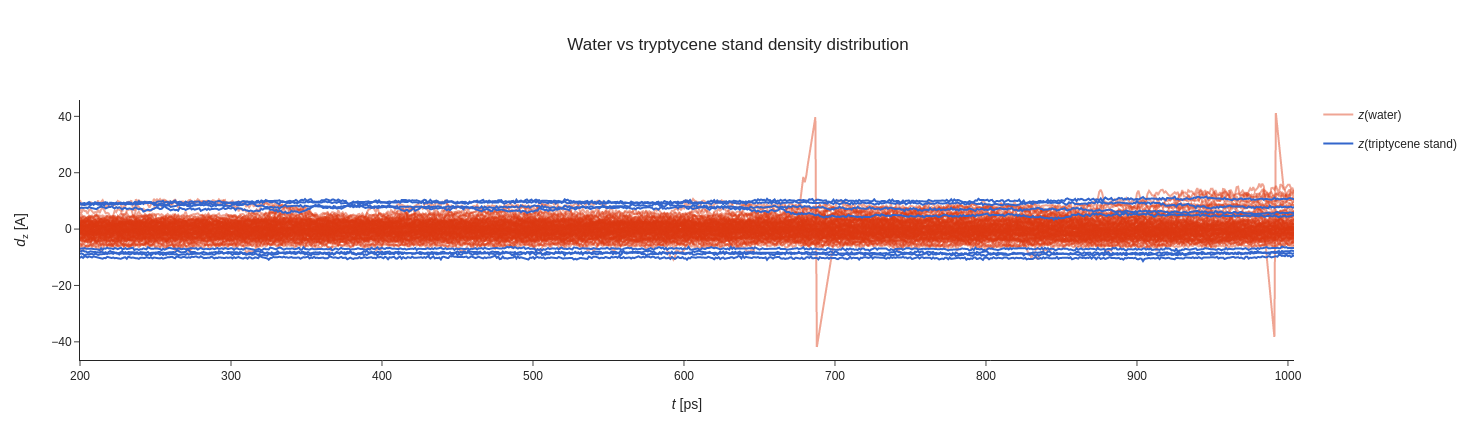

In [5]:
obs = filter_keys('z_distribution', dick = dfs[SYSTEM_NAME])
_temp = {}

for i in obs.keys():
    dfs[SYSTEM_NAME][i] = pd.read_csv(csv_files[SYSTEM_NAME][i], delimiter=",", index_col=0)
    _temp[i] = (dfs[SYSTEM_NAME][i])

fig = plot_z_dist(_temp['z_distribution_water_timedev'], _temp['z_distribution_stand_timedev'], color_scheme)
fig.show()

&rarr; &emsp;[Content](#content)  

<a name="lt"></a>
## **Triptycene stand tilt**
***

In [6]:
PROPERTY_NAME = '_lower_tilt'

_temp = {}
obs = {}
mean_hist = {}
fig = {}

out = {ul : widgets.Output(), ll: widgets.Output()} #layout=Layout(width='auto',  display='inline-block')

tab = widgets.Tab(children = [out[ul], out[ll]]) # layout=Layout(width='auto',  display='inline-block')
tab.set_title(0, 'UPPER LAYER')
tab.set_title(1, 'LOWER LAYER')
display(tab)  

for lyr in [ul, ll]:
    key_name = lyr+PROPERTY_NAME
    obs[lyr] = filter_keys(key_name, dick = dfs[SYSTEM_NAME])

    for i in (obs[lyr]).keys():
        dfs[SYSTEM_NAME][i] = pd.read_csv(csv_files[SYSTEM_NAME][i], delimiter=",", index_col=0)
        _temp[i] = (dfs[SYSTEM_NAME][i])
      
        
    with out[lyr]:
        mean_hist[lyr] = pd.concat((_temp[key_name+'_timedev'])[i] for i in (_temp[key_name+'_timedev']).columns)
        fig[lyr] = plot_timedev((_temp[key_name+'_timedev'])[list(lyr)],
                                (_temp[key_name+'_timedev'])[['mean', 'lci', 'uci']], 
                                mean_hist[lyr], PROPERTY_NAME, SYSTEM_NAME, color_scheme, obs = 'angle_type')
        display(fig[lyr])
        display(tabulate_stats(_temp[key_name+'_stat'], 
                               pd.read_csv(csv_files[SYSTEM_NAME]['lower_tilt_kendall_corr_matrix'], delimiter=",", index_col=0), 
                               PROPERTY_NAME, good_layer = list(lyr)))

&rarr; &emsp;[Content](#content)  

<a name="ut"></a>
## **Functional head tilt**
***

In [7]:
PROPERTY_NAME = '_upper_tilt'

_temp = {}
obs = {}
mean_hist = {}
fig = {}

out = {ul : widgets.Output(), ll: widgets.Output()} #layout=Layout(width='auto',  display='inline-block')

tab = widgets.Tab(children = [out[ul], out[ll]]) # layout=Layout(width='auto',  display='inline-block')
tab.set_title(0, 'UPPER LAYER')
tab.set_title(1, 'LOWER LAYER')
display(tab)  

for lyr in [ul, ll]:
    key_name = lyr+PROPERTY_NAME
    obs[lyr] = filter_keys(key_name, dick = dfs[SYSTEM_NAME])

    for i in (obs[lyr]).keys():
        dfs[SYSTEM_NAME][i] = pd.read_csv(csv_files[SYSTEM_NAME][i], delimiter=",", index_col=0)
        _temp[i] = (dfs[SYSTEM_NAME][i])
      
        
    with out[lyr]:
        mean_hist[lyr] = pd.concat((_temp[key_name+'_timedev'])[i] for i in (_temp[key_name+'_timedev']).columns)
        fig[lyr] = plot_timedev((_temp[key_name+'_timedev'])[list(lyr)],
                                (_temp[key_name+'_timedev'])[['mean', 'lci', 'uci']], 
                                mean_hist[lyr], PROPERTY_NAME, SYSTEM_NAME, color_scheme, obs = 'angle_type')
        display(fig[lyr])
        display(tabulate_stats(_temp[key_name+'_stat'], 
                               pd.read_csv(csv_files[SYSTEM_NAME]['upper_tilt_kendall_corr_matrix'], delimiter=",", index_col=0), 
                               PROPERTY_NAME, good_layer = list(lyr)))

&rarr; &emsp;[Content](#content)  

<a name="bend"></a>
## **Functional head bend**
***

In [8]:
PROPERTY_NAME = '_bend'

_temp = {}
obs = {}
mean_hist = {}
fig = {}

out = {ul : widgets.Output(), ll: widgets.Output()} #layout=Layout(width='auto',  display='inline-block')

tab = widgets.Tab(children = [out[ul], out[ll]]) # layout=Layout(width='auto',  display='inline-block')
tab.set_title(0, 'UPPER LAYER')
tab.set_title(1, 'LOWER LAYER')
display(tab)  

for lyr in [ul, ll]:
    key_name = lyr+PROPERTY_NAME
    obs[lyr] = filter_keys(key_name, dick = dfs[SYSTEM_NAME])

    for i in (obs[lyr]).keys():
        dfs[SYSTEM_NAME][i] = pd.read_csv(csv_files[SYSTEM_NAME][i], delimiter=",", index_col=0)
        _temp[i] = (dfs[SYSTEM_NAME][i])
          
    with out[lyr]:
        mean_hist[lyr] = pd.concat((_temp[key_name+'_timedev'])[i] for i in (_temp[key_name+'_timedev']).columns)
        fig[lyr] = plot_timedev((_temp[key_name+'_timedev'])[list(lyr)],
                                (_temp[key_name+'_timedev'])[['mean', 'lci', 'uci']], 
                                mean_hist[lyr], PROPERTY_NAME, SYSTEM_NAME, color_scheme, obs = 'angle_type')
        display(fig[lyr])
        display(tabulate_stats(_temp[key_name+'_stat'], 
                               pd.read_csv(csv_files[SYSTEM_NAME]['bend_kendall_corr_matrix'], delimiter=",", index_col=0), 
                               PROPERTY_NAME, good_layer = list(lyr)))

&rarr; &emsp;[Content](#content)  

<a name="dist"></a>
## **Functional head / triptycene stand interactions**
***

In [10]:
PROPERTY_NAME = '_minimal_fh_stand_distance'

_temp = {}
obs = {}
mean_hist = {}
fig = {}

out = {ul : widgets.Output(), ll: widgets.Output()} #layout=Layout(width='auto',  display='inline-block')

tab = widgets.Tab(children = [out[ul], out[ll]]) # layout=Layout(width='auto',  display='inline-block')
tab.set_title(0, 'UPPER LAYER')
tab.set_title(1, 'LOWER LAYER')
display(tab)  

for lyr in [ul, ll]:
    key_name = lyr+PROPERTY_NAME
    obs[lyr] = filter_keys(key_name, dick = dfs[SYSTEM_NAME])

    for i in (obs[lyr]).keys():
        dfs[SYSTEM_NAME][i] = pd.read_csv(csv_files[SYSTEM_NAME][i], delimiter=",", index_col=0)
        _temp[i] = (dfs[SYSTEM_NAME][i])
        
    with out[lyr]:
        fig[lyr] = plot_minimal_distance(_temp[key_name+'_timedev'], PROPERTY_NAME, SYSTEM_NAME, color_scheme)
        display(fig[lyr])
        _temp[key_name+'_stat'] = _temp[key_name+'_stat'] .style.set_caption(PROPERTY_NAME + ' statistics').set_table_styles(caption_style)
        display(_temp[key_name+'_stat'])

&rarr; &emsp;[Content](#content)  

<a name="cdf"></a>
## **Combined distribution functions**
***

In [ ]:
PROPERTY_NAME = '_cdf_rdf'

_temp = {}
obs = {}
mean_hist = {}
fig = {}

cdf = {ul : widgets.Output(), ll: widgets.Output()} #layout=Layout(width='auto',  display='inline-block')

tab = widgets.Tab(children = [cdf[ul], cdf[ll]]) # layout=Layout(width='auto',  display='inline-block')
tab.set_title(0, 'UPPER LAYER')
tab.set_title(1, 'LOWER LAYER')
display(tab)  

for lyr in [ul, ll]:
    key_name = lyr+PROPERTY_NAME
    obs[lyr] = filter_keys(key_name, dick = dfs[SYSTEM_NAME])
    
    for i in (obs[lyr]).keys():
        dfs[SYSTEM_NAME][i] = pd.read_csv(csv_files[SYSTEM_NAME][i], delimiter=",", index_col=0)
        _temp[i] = (dfs[SYSTEM_NAME][i])
    
    with cdf[lyr]:
        fig[lyr] = plot_cdf(_temp[key_name+'_adf_2d_hist'], _temp[key_name+'_adf_2d_corr_hist'],
                            _temp[key_name+'_rdf_2d_hist'], _temp[key_name+'_rdf_2d_corr_hist'],
                            PROPERTY_NAME, SYSTEM_NAME)
        display(fig[lyr])

&rarr; &emsp;[Content](#content)  